# <span style="color:pink">Project part 2.4.0.2</span>

<span style="color:pink">**_Zofia Różańska, 280526_**</span>

<span style="color:pink">_Dataset: Estimation of Obesity Levels Based On Eating Habits and Physical Condition_</span>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [3]:
# Load the dataset
dataset_url = 'https://raw.githubusercontent.com/zosia-r/msid/refs/heads/main/I/dataset.csv'
data = pd.read_csv(dataset_url)

# Display all columns and rows in the DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(data.head())

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

## <span style="color:pink">Logistic Regression</span>

### <span style="color:pink">Preprocessing</span>

In [4]:
# Separate features and target
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

In [5]:
def preprocess(X):
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Define the preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    return preprocessor

In [6]:
# Split data into trainig, validating and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [7]:
# Perform preprocessing on X
preprocessor = preprocess(X)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


In [8]:
# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [9]:
class LogisticRegressionOVR:
    def __init__(self, lr=0.1, epochs=1000, batch_size=32):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes_ = None
        self.thetas_ = {}

    def sigmoid(self, z):
        ''' Sigmoid activation function for binary logistic regression '''

        return 1 / (1 + np.exp(-z))

    def cross_entropy_loss(self, y_true, y_pred):
        ''' Cross-entropy loss to measure prediction error '''

        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    def _train_binary_classifier(self, X, y_binary, X_val, y_val_binary):
        ''' Trains one binary logistic regression model for a given class.
        y_binary is 1 for this class, 0 for all others. '''

        m, n = X.shape
        theta = np.zeros(n + 1)  # Initialize weights (including bias)
        X_bias = np.hstack([np.ones((m, 1)), X])  # Add bias column (ones)

        X_val_bias = np.hstack([np.ones((X_val.shape[0], 1)), X_val])  # Add bias column for validation

        for epoch in range(self.epochs):
            # Shuffle data for each epoch
            indices = np.random.permutation(m)
            X_shuffled = X_bias[indices]
            y_shuffled = y_binary[indices]

            for i in range(0, m, self.batch_size):
                # Create a batch
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                predictions = self.sigmoid(X_batch @ theta)

                # Compute error and gradient
                error = predictions - y_batch
                gradient = X_batch.T @ error / len(y_batch)

                # Update weights
                theta -= self.lr * gradient

        # Validation stats
        val_predictions = self.sigmoid(X_val_bias @ theta)
        val_loss = self.cross_entropy_loss(y_val_binary, val_predictions)
        val_acc = np.mean((val_predictions >= 0.5) == y_val_binary)
        print(f"Epoch {epoch + 1} | Cross-entropy loss: {val_loss:.3f} | Val Accuracy: {val_acc*100:.3f}%")


        return theta  # Return the learned weights for this class

    def fit(self, X, y, X_val, y_val):
        ''' Trains the model using One-vs-Rest (OvR) strategy.'''

        start_time = time.time() # Start time for training
        
        self.classes_ = np.unique(y)
        for cls in self.classes_:
            # Create binary target: 1 if sample belongs to cls, else 0
            y_binary = (y == cls).astype(int)
            y_val_binary = (y_val == cls).astype(int)
            theta = self._train_binary_classifier(X, y_binary, X_val, y_val_binary)
            self.thetas_[cls] = theta

        end_time = time.time()
        total_training_time = end_time - start_time  # Time in seconds

        print(f"\nTraining completed in {total_training_time:.2f} seconds.")

    def predict_proba(self, X):
        ''' Predicts probabilities for each class.
        Returns shape: (num_samples, num_classes) '''

        m = X.shape[0]
        X_bias = np.hstack([np.ones((m, 1)), X])  # Add bias term
        probs = np.zeros((m, len(self.classes_)))

        for idx, cls in enumerate(self.classes_):
            theta = self.thetas_[cls]
            probs[:, idx] = self.sigmoid(X_bias @ theta)  # Compute class probability

        return probs

    def predict(self, X):
        ''' Predict the class with the highest probability. '''
    
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]


In [10]:
# Train the model
clf = LogisticRegressionOVR(lr=0.01, epochs=1000, batch_size=32)
clf.fit(X_train, y_train_encoded, X_val, y_val_encoded)

Epoch 1000 | Cross-entropy loss: 0.036 | Val Accuracy: 99.052%
Epoch 1000 | Cross-entropy loss: 0.138 | Val Accuracy: 86.256%
Epoch 1000 | Cross-entropy loss: 0.190 | Val Accuracy: 86.967%
Epoch 1000 | Cross-entropy loss: 0.030 | Val Accuracy: 99.289%
Epoch 1000 | Cross-entropy loss: 0.003 | Val Accuracy: 100.000%
Epoch 1000 | Cross-entropy loss: 0.211 | Val Accuracy: 86.730%
Epoch 1000 | Cross-entropy loss: 0.229 | Val Accuracy: 85.071%

Training completed in 3.75 seconds.


Cross-entropy loss: 1.061
Accuracy: 76.832%
Classification report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.80      0.95      0.87        55
      Normal_Weight       0.63      0.44      0.52        55
     Obesity_Type_I       0.68      0.74      0.71        69
    Obesity_Type_II       0.86      1.00      0.92        66
   Obesity_Type_III       0.96      1.00      0.98        68
 Overweight_Level_I       0.70      0.67      0.69        55
Overweight_Level_II       0.61      0.49      0.55        55

           accuracy                           0.77       423
          macro avg       0.75      0.75      0.75       423
       weighted avg       0.76      0.77      0.76       423



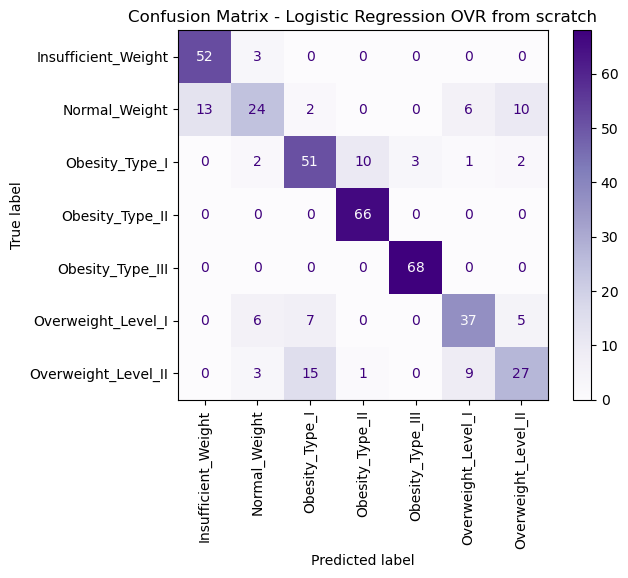

In [11]:
# Evaluate the model
y_pred = clf.predict(X_test)

# Decode the predictions back to original labels
y_pred_labels = le.inverse_transform(y_pred)

# Get encoded labels for test data
y_test_encoded = le.transform(y_test)

print(f'Cross-entropy loss: {clf.cross_entropy_loss(y_test_encoded, y_pred):.3f}')
print(f'Accuracy: {accuracy_score(y_test_encoded, y_pred)*100:.3f}%')
print('Classification report:\n', classification_report(y_test, y_pred_labels))


# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap=plt.cm.Purples)
plt.title("Confusion Matrix - Logistic Regression OVR from scratch")
plt.show()

In [12]:
# Evaluate the model on training data
y_train_pred = clf.predict(X_train)

# Decode the predictions back to original labels
y_train_pred_labels = le.inverse_transform(y_train_pred)

# Get encoded labels for training data
y_train_encoded = le.transform(y_train)

print(f'Cross-entropy loss on training data: {clf.cross_entropy_loss(y_train_encoded, y_train_pred):.3f}')
print(f'Accuracy on training data: {accuracy_score(y_train_encoded, y_train_pred)*100:.3f}%')

Cross-entropy loss on training data: 0.709
Accuracy on training data: 76.619%


# <span style="color:pink">Project part III</span>

## <span style="color:pink">Cross validation</span>

In [13]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []

y = le.transform(y)  # Encode the target variable for cross-validation
X = preprocessor.transform(X)  # Preprocess the entire dataset

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    # Split the data
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Train the model
    clf_fold = LogisticRegressionOVR(lr=0.01, epochs=1000, batch_size=32)
    clf_fold.fit(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

    # Predict
    y_val_pred = clf_fold.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(acc)
    print(f'Fold {fold+1} accuracy: {acc:.4f}')

# Mean accuracy
print('-----')
print('Mean accuracy (cross-val):', np.mean(accuracies)*100, '%')


Epoch 1000 | Cross-entropy loss: 0.027 | Val Accuracy: 98.864%
Epoch 1000 | Cross-entropy loss: 0.162 | Val Accuracy: 87.216%
Epoch 1000 | Cross-entropy loss: 0.211 | Val Accuracy: 87.074%
Epoch 1000 | Cross-entropy loss: 0.031 | Val Accuracy: 99.290%
Epoch 1000 | Cross-entropy loss: 0.004 | Val Accuracy: 100.000%
Epoch 1000 | Cross-entropy loss: 0.235 | Val Accuracy: 86.790%
Epoch 1000 | Cross-entropy loss: 0.201 | Val Accuracy: 86.080%

Training completed in 3.99 seconds.
Fold 1 accuracy: 0.7656
Epoch 1000 | Cross-entropy loss: 0.025 | Val Accuracy: 98.580%
Epoch 1000 | Cross-entropy loss: 0.171 | Val Accuracy: 86.648%
Epoch 1000 | Cross-entropy loss: 0.230 | Val Accuracy: 86.222%
Epoch 1000 | Cross-entropy loss: 0.033 | Val Accuracy: 98.438%
Epoch 1000 | Cross-entropy loss: 0.004 | Val Accuracy: 100.000%
Epoch 1000 | Cross-entropy loss: 0.214 | Val Accuracy: 86.222%
Epoch 1000 | Cross-entropy loss: 0.204 | Val Accuracy: 86.222%

Training completed in 3.99 seconds.
Fold 2 accuracy: 0